# Data Exploration and Dataset re-build 

In [178]:
import os
from query_tool import M100DataClient
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime
import calendar
import re
from datetime import timedelta

plt.style.use("seaborn-v0_8")

---
## Setting constants and options

### Dataset location:

In [179]:
DATASET_FOLDER = "./dataset/"
DATASET_FOLDER_ORIGINAL = DATASET_FOLDER + "original/"
DATASET_FOLDER_REBUILD = DATASET_FOLDER + "rebuild/"

### Year and Month of the original dataset:

In [180]:
YEAR = 2022
MONTH = 9

### Sampling rate of Nagios:

In [181]:
NAGIOS_TIME_DELTA_MINS = 15  # in minutes

### Flag indicating whether or not to print graphs:

In [182]:
DISPLAY_GRAPHS = False

---
## Preliminary operations

In [183]:
# Make the new "rebuild" folder if not existing
first_day = datetime(YEAR, MONTH, 1)
last_day = calendar.monthrange(first_day.year, first_day.month)[1]
all_days = np.arange(first_day, last_day, dtype="datetime64[D]")
dataset_path_rebuild = DATASET_FOLDER_REBUILD + first_day.strftime("%y-%m")
os.makedirs(dataset_path_rebuild, exist_ok=True)

# Compose the path to the original dataset
dataset_path_original = (
    DATASET_FOLDER_ORIGINAL + first_day.strftime("%y-%m") + "/year_month=" + first_day.strftime("%y-%m")
)
print(f"Original dataset path: '{dataset_path_original}'")
if not os.path.exists(dataset_path_original):
    raise FileNotFoundError(f"Path of the original dataset '{dataset_path_original}' does not exist!")

Original dataset path: './dataset/original/22-09/year_month=22-09'


In [184]:
# Query tool
client = M100DataClient(dataset_path_original)

In [185]:
# Detect non-numerical features
all_non_numerical_features = {
    key: value
    for key, value in client.dtype_per_metric.items()
    if not any(t in str(value) for t in ["float", "int", "double"])
}
all_non_numerical_features

{'machine_type': DataType(string),
 'gexec': DataType(string),
 'os_name': DataType(string),
 'os_release': DataType(string),
 'Prototype': DataType(string),
 'address': DataType(string),
 'Gateway': DataType(string),
 'job_info_marconi100': None}

In [186]:
# Method for detecting non-numerical features for a given plugin
def metrics_description(plugin, verbose=True):
    """
    Returns a list of all non-numerical metrics of a given plugin.

    Parameters
    ----------
    plugin: str
        The name of the name of the plugin.
    verbose: bool, optional
        Whether or not to print additional information. The default is True.

    Returns
    -------
    non_numerical: list
        A list of all non-numerical metrics of the given plugin.

    """
    if verbose:
        for metric in client.metrics_per_plugin[plugin]:
            print("metric: '{}'".format(metric))
            print("\tdtype:", client.dtype_per_metric[metric])
            print("\ttags:", client.tags_per_metric[metric])
        print("----------------------------------------------------------------")
    non_numerical = list(
        metric for metric in client.metrics_per_plugin[plugin] if metric in all_non_numerical_features.keys()
    )
    if verbose:
        print(
            "NON NUMERICAL METRICS:",
            non_numerical,
        )
    return non_numerical

---
## Detect nodes with the most data available

In [187]:
%%script false --no-raise-error

# Highest node number, among the ones appearing in the Nagios dataset (since it's the most important metric)
highest_nodeID = (
    client.query_plugins(plugins=["nagios"], columns=["node"])
    .astype(int)
    .sort_values(by="node", ascending=False)
    .values[0][0]
)
# Dataframe with one column of zeros, with a row for each node (even if the node doesn't exist)
nodes_rows = pd.DataFrame({"samples_number": [0] * highest_nodeID}, dtype=int)
# Dataframe with one column of a sequential index, one per node (even if the node doesn't exist)
fill_na_rows = pd.DataFrame({"node": range(0, highest_nodeID + 1, 1)}, dtype=int)

for plugin, metrics in client.metrics_per_plugin.items():
    for met in metrics:
        # Create dataset with {nodeID, number of rows of the metric}
        results = (
            client.query(metrics=[met], columns=["node"])
            .groupby("node", observed=False)
            .size()
            .reset_index(name="samples_number")
            .astype({"node": int})
            .sort_values("node")
            .reset_index(drop=True)
        )
        # Add to the results the rows (the nodes) that are not present (that are the one that hasn't any observation in this metric), and they'll have the "samples_number" column set to NaN
        results = pd.merge(fill_na_rows, results, on="node", how="left")
        # Set to 0 the "samples_number" of the nodes not present in this metric. And sum them to the big dataframe that contains the observation count of all metrics of each node
        nodes_rows["samples_number"] += results["samples_number"].fillna(0)

display(
    nodes_rows.sort_values(by="samples_number", ascending=False)
    .head(10)
    .style.set_caption("Nodes with most data available")
    .format(precision=0)
)

Couldn't find program: 'false'


In [188]:
# Results:

# Node  Total_Samples
# 3	    28246529
# 1	    28246382
# 2	    28243448
# 0	    28219495
# 880	27026042
# 703	27023216
# 334	27020755
# 41	27011895
# 961	27008536
# 585	27003582

# Detect nodes with most Nagios anomalies (nagiosdrained=1)
Filters:
- filter out the nodes that have ALL nagiosdrained values = 1 or = 0
- filter out the nodes that start with nagiosdrained = 1, because we'd like to observe the false positive predictions of anomalies
- filter in only the nodes with at least two separate raised nagiosdrained flags

In [189]:
# get the nagios data
nodes_most_anomalies = client.query_plugins(plugins=["nagios"], columns=["node", "nagiosdrained", "timestamp"])

# filter OUT the nodes that have ALL nagiosdrained values = 1 or = 0
nodes_most_anomalies = nodes_most_anomalies.groupby("node", observed=False).filter(
    lambda x: not all(x["nagiosdrained"] == "0") and not all(x["nagiosdrained"] == "1")
)

# filter OUT nodes that start with nagiosdrained = 1
nodes_most_anomalies = nodes_most_anomalies.groupby("node", observed=False).filter(
    lambda x: len(x) > 0 and x.sort_values(by="timestamp").iloc[0]["nagiosdrained"] != "1"
)

# filter IN nodes that have at least two separate raised nagiosdrained flags
nodes_most_anomalies = nodes_most_anomalies.groupby("node", observed=False).filter(
    lambda x: re.search("^0+1+0+1+", "".join(x.sort_values(by="timestamp")["nagiosdrained"])) is not None
)

nodes_most_anomalies = (
    nodes_most_anomalies.groupby("node", observed=False)
    .size()  # get number of samples for each node
    .reset_index(name="nagios_samples_number")  # move the number of samples to a proper column
    .astype({"node": int})  # convert the node to integer
    .sort_values(by="nagios_samples_number", ascending=False)  # sort the number of samples
    .reset_index(drop=True)
    .loc[lambda x: x["nagios_samples_number"] != 0]  # remove nodes with zero samples
)

display(nodes_most_anomalies.head(20).style.set_caption("Best selected nodes"))

,node,nagios_samples_number
0,104,42672
1,578,42672
2,355,42672
3,10,40005


In [190]:
# good examples: 104, 10, 38, 335
NODE_SELECTED = "355"

In [191]:
# Clear memory
%reset_selective -f ^first_day$
%reset_selective -f ^last_day$
%reset_selective -f ^YEAR$
%reset_selective -f ^MONTH$
%reset_selective -f ^DATASET_FOLDER$

---
---
# Nagios Plugin

In [192]:
non_numerical_features = metrics_description("nagios")

metric: 'state'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'description', 'host_group', 'nagiosdrained', 'node', 'state_type']
----------------------------------------------------------------
NON NUMERICAL METRICS: []


### Get data:

In [193]:
df_nagios = client.query_plugins(plugins="nagios", node=NODE_SELECTED).sort_values(by="timestamp", ascending=True)

df_nagios.info()
display(df_nagios.head(3))

<class 'pandas.core.frame.DataFrame'>
Index: 42672 entries, 0 to 33092
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp      42672 non-null  datetime64[ms, UTC]
 1   plugin         42672 non-null  category           
 2   state_type     42672 non-null  string             
 3   metric         42672 non-null  category           
 4   value          42672 non-null  Int32              
 5   nagiosdrained  42672 non-null  string             
 6   node           42672 non-null  category           
 7   year_month     0 non-null      category           
 8   description    42672 non-null  category           
 9   host_group     42672 non-null  category           
dtypes: Int32(1), category(6), datetime64[ms, UTC](1), string(2)
memory usage: 1.9 MB


,timestamp,plugin,state_type,metric,value,nagiosdrained,node,year_month,description,host_group
0,2022-09-01 00:00:00+00:00,nagios_pub,1,state,0,0,355,NaN,alive::ping,compute
176,2022-09-01 00:00:00+00:00,nagios_pub,1,state,0,0,355,NaN,batchs::client,compute
264,2022-09-01 00:00:00+00:00,nagios_pub,1,state,0,0,355,NaN,bmc::events,compute


### Cleaning rows and columns:

In [194]:
df_nagios = df_nagios[["description", "value", "timestamp", "nagiosdrained"]]

# Present descriptions
descriptions = df_nagios["description"].sort_values().unique()

### Display graphs:

In [195]:
if DISPLAY_GRAPHS:
    for descr in descriptions:
        _, axes = plt.subplots(figsize=(16, 3))
        df_nagios_plot = df_nagios.loc[df_nagios["description"] == descr][["timestamp", "value", "nagiosdrained"]]
        axes.plot(df_nagios_plot["timestamp"], df_nagios_plot["value"], label="state")
        axes.plot(df_nagios_plot["timestamp"], df_nagios_plot["nagiosdrained"].astype(int), label="nagiosdrained")
        axes.set_title("{}\n {}\n (node {})".format("nagios", descr, NODE_SELECTED))
        axes.legend()
        axes.set_xticks(all_days)
        axes.tick_params(axis="x", labelrotation=10)
        axes.xaxis.set_major_locator(MaxNLocator(nbins=15))
        axes.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        axes.set_yticks([0, 1, 2, 3])
        plt.tight_layout()
        plt.show()

## Verifications:

In [196]:
# Null rows
if df_nagios.shape[0] - df_nagios.dropna().shape[0] != 0:
    raise Exception("There are null rows in the nagios dataframe")

In [197]:
# Verify that the timestamps of all the descriptions are equal
is_equal_descr = True
df_temp = df_nagios.loc[df_nagios["description"] == descriptions[0]].reset_index()["timestamp"]
for descr in descriptions[1:]:
    is_equal_descr = (
        is_equal_descr
        and (df_temp == df_nagios.loc[df_nagios["description"] == descr].reset_index()["timestamp"]).all()
    )
if not is_equal_descr:
    raise Exception("Not all description timestamps are equal")

In [198]:
# Verify that "nagiosdrained" of all the descriptions is equal
is_equal_nagios_drained = True
df_temp = df_nagios.loc[df_nagios["description"] == descriptions[0]].reset_index()["nagiosdrained"]
for descr in descriptions:
    is_equal_nagios_drained = (
        is_equal_nagios_drained
        and (df_temp == df_nagios.loc[df_nagios["description"] == descr].reset_index()["nagiosdrained"]).all()
    )

if not is_equal_nagios_drained:
    raise Exception("Not all description nagiosdrained are equal")

In [199]:
# Verify if the timestamps are equally spaced and if there are time holes.


def check_timestamps(timestamps):
    ts_temp = None
    for ts in timestamps:
        if ts_temp != None:
            if ts - ts_temp != timedelta(minutes=NAGIOS_TIME_DELTA_MINS):
                missing_intervals = (ts - ts_temp) // timedelta(minutes=NAGIOS_TIME_DELTA_MINS) - 1
                print(
                    "There is a time hole of {} timestamps, between these *present* timestamps: \n {}\n {}\n".format(
                        missing_intervals, ts_temp, ts
                    )
                )
        ts_temp = ts


# Take the timestamps of one casual (the first) description since they're all equal
df_temp = df_nagios.loc[df_nagios["description"] == descriptions[0]].reset_index()["timestamp"]
check_timestamps(df_temp)

There is a time hole of 3 timestamps, between these *present* timestamps: 
 2022-09-12 20:30:00+00:00
 2022-09-12 21:30:00+00:00

There is a time hole of 2 timestamps, between these *present* timestamps: 
 2022-09-13 08:15:00+00:00
 2022-09-13 09:00:00+00:00

There is a time hole of 5 timestamps, between these *present* timestamps: 
 2022-09-13 09:45:00+00:00
 2022-09-13 11:15:00+00:00

There is a time hole of 1 timestamps, between these *present* timestamps: 
 2022-09-13 12:30:00+00:00
 2022-09-13 13:00:00+00:00

There is a time hole of 2 timestamps, between these *present* timestamps: 
 2022-09-20 08:45:00+00:00
 2022-09-20 09:30:00+00:00



## Build the new dataframe

In [200]:
df_nagios_rebuild = pd.DataFrame()

# Downcast to int8 to save some space
df_nagios["nagiosdrained"] = pd.to_numeric(df_nagios["nagiosdrained"], downcast="integer")
df_nagios["value"] = pd.to_numeric(df_nagios["value"], downcast="integer")


for descr in descriptions:
    # Build a new temporary df for each description
    df_temp = df_nagios.loc[df_nagios["description"] == descr][["timestamp", "nagiosdrained", "value"]].rename(
        columns={"value": str(descr)}
    )
    if df_nagios_rebuild.empty:
        df_nagios_rebuild = df_temp
    else:
        # Merge the temporary df to the main df
        df_nagios_rebuild = pd.merge(df_nagios_rebuild, df_temp, on=["timestamp", "nagiosdrained"])

# Set timestamp as index
df_nagios_rebuild = df_nagios_rebuild.set_index("timestamp")

display(df_nagios_rebuild.head(3))
df_nagios_rebuild.info()

,nagiosdrained,alive::ping,batchs::client::state,batchs::client,bmc::events,filesys::eurofusion::mount,filesys::local::avail,filesys::local::mount,memory::phys::total,net::ib::status,nvidia::configuration,nvidia::memory::replace,nvidia::memory::retirement,ssh::daemon,sys::rvitals,sys::gpfs::status,sys::sssd::events
timestamp,,,,,,,,,,,,,,,,,
2022-09-01 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022-09-01 00:15:00+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022-09-01 00:30:00+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2022-09-01 00:00:00+00:00 to 2022-09-28 21:45:00+00:00
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   nagiosdrained               2667 non-null   Int8 
 1   alive::ping                 2667 non-null   Int8 
 2   batchs::client::state       2667 non-null   Int8 
 3   batchs::client              2667 non-null   Int8 
 4   bmc::events                 2667 non-null   Int8 
 5   filesys::eurofusion::mount  2667 non-null   Int8 
 6   filesys::local::avail       2667 non-null   Int8 
 7   filesys::local::mount       2667 non-null   Int8 
 8   memory::phys::total         2667 non-null   Int8 
 9   net::ib::status             2667 non-null   Int8 
 10  nvidia::configuration       2667 non-null   Int8 
 11  nvidia::memory::replace     2667 non-null   Int8 
 12  nvidia::memory::retirement  2667 non-null   Int8 
 13  ssh::daemon    

### Save rebuilt dataframe:

In [201]:
df_nagios_rebuild.to_csv(dataset_path_rebuild + "/nagios_rebuild_node" + NODE_SELECTED + ".csv", index=True)

### Extract valuable Nagios informations:

In [202]:
# Number of nagios samples
nagios_sample_number = df_nagios_rebuild.shape[0]
# First and last nagios timestamps
first_nagios_timestamp, last_nagios_timestamp = df_nagios_rebuild.index[0], df_nagios_rebuild.index[-1]

In [203]:
# Clean up memory
%reset_selective -f ^df_
%reset_selective -f ^descr
%reset_selective -f ^ax
%reset_selective -f ^is_equal_

---
---
# Ganglia Plugin

In [204]:
non_numerical_features = metrics_description(plugin="ganglia", verbose=False)
non_numerical_features

['machine_type', 'gexec', 'os_name', 'os_release']

### Get data:

In [205]:
df_ganglia: pd.DataFrame = (
    client.query_plugins(plugins="ganglia", node=NODE_SELECTED)
    .sort_values(by="timestamp", ascending=True)
    .reset_index(drop=True)
)

df_ganglia.info()
display(df_ganglia.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15704825 entries, 0 to 15704824
Data columns (total 6 columns):
 #   Column      Dtype              
---  ------      -----              
 0   year_month  category           
 1   timestamp   datetime64[ms, UTC]
 2   plugin      category           
 3   metric      category           
 4   value       object             
 5   node        category           
dtypes: category(4), datetime64[ms, UTC](1), object(1)
memory usage: 329.6+ MB


,year_month,timestamp,plugin,metric,value,node
0,NaN,2022-09-01 00:00:12+00:00,ganglia_pub,disk_free,1135.234009,355
1,NaN,2022-09-01 00:00:12+00:00,ganglia_pub,Gpu1_current_clock_throttle_reasons,0.0,355
2,NaN,2022-09-01 00:00:12+00:00,ganglia_pub,Gpu2_thermal_violation,0.0,355


### Cleaning rows and columns:

In [206]:
df_ganglia = df_ganglia[["timestamp", "value", "metric"]].reset_index(drop=True)

In [207]:
# Remove metrics that don't change in value
def remove_non_changing_metrics(df: pd.DataFrame):
    to_remove = []
    # for each metric
    for metric in df["metric"].sort_values().unique():
        # temporary df with only this metric
        df_temp: pd.DataFrame = df.loc[df["metric"] == metric]
        # if all values of the metric are equal...
        if (df_temp["value"] == df_temp["value"].tolist()[0]).all():
            to_remove.append(metric)
    # return original df without selected metrics
    return df.loc[~df["metric"].isin(to_remove)].reset_index(drop=True)


df_ganglia = remove_non_changing_metrics(df_ganglia)

In [208]:
# Verify if non-numerical metrics have distinct values
def detect_distinct_non_numerical_values(df: pd.DataFrame):
    for feature in non_numerical_features:
        # if the feature is still in the df...
        # (if it doesn't change in value, it's removed in the previous step)
        if feature in df["metric"].values:
            # Extract unique values
            distinct_values = df.loc[df["metric"] == feature]["value"].unique()
            print("Distinct values for non-numerical metric '{}': {}".format(feature, distinct_values))
            # Raise an exception if there are any
            if len(distinct_values) > 1:
                raise Exception("There are more than one distinct values for metric '{}'.".format(feature))


detect_distinct_non_numerical_values(df_ganglia)

In [209]:
# Present (remaining) metrics
metrics = df_ganglia["metric"].sort_values().unique()

### Display graphs:

In [210]:
if DISPLAY_GRAPHS:
    # Divide into different categories to not print an excessive number of plots
    ganglia_metrics_available = df_ganglia["metric"].unique()
    ganglia_metrics_dict = {
        "gpu0": [s for s in ganglia_metrics_available if s.startswith("Gpu0")],
        "gpu1": [s for s in ganglia_metrics_available if s.startswith("Gpu1")],
        "gpu2": [s for s in ganglia_metrics_available if s.startswith("Gpu2")],
        "gpu3": [s for s in ganglia_metrics_available if s.startswith("Gpu3")],
        "system": [s for s in ganglia_metrics_available if s in ["boottime", "machine_type", "os_name", "os_release"]],
        "network": [s for s in ganglia_metrics_available if s in ["bytes_in", "bytes_out", "pkts_in", "pkts_out"]],
        "cpu": [s for s in ganglia_metrics_available if s.startswith("cpu")],
        "disk": [s for s in ganglia_metrics_available if s.startswith("disk") or s in ["part_max_used"]],
        "core": [s for s in ganglia_metrics_available if s in ["gexec"]],
        "load": [s for s in ganglia_metrics_available if s.startswith("load")],
        "memory": [s for s in ganglia_metrics_available if s.startswith("mem") or s.startswith("swap")],
        "process": [s for s in ganglia_metrics_available if s.startswith("proc")],
    }

In [211]:
if DISPLAY_GRAPHS:
    # MinMax to make visible all the data
    from sklearn.preprocessing import MinMaxScaler

    for metric_name, val in ganglia_metrics_dict.items():
        _, axes = plt.subplots(figsize=(16, 5))
        empty = True
        for met in val:
            df_metric = df_ganglia.loc[df_ganglia["metric"] == met][["timestamp", "value"]]

            # Unnecessary code if are executed the above functions "remove_non_changing_metrics()" and "detect_distinct_non_numerical_values()"
            """
            # Remove metrics with unmuted values
            if (df_metric["value"] == df_metric["value"].tolist()[0]).all():
                continue

            # Remove metrics non numerical
            if ~df_metric["value"].apply(lambda x: pd.to_numeric(x, errors="coerce")).notnull().all():
                continue
            """

            empty = False

            # Scaling for plotting
            df_metric["value"] = MinMaxScaler().fit_transform(df_metric[["value"]].astype(float))
            sns.scatterplot(df_metric, x="timestamp", y="value", edgecolor="none", s=10, label=met, ax=axes)
            axes.set_title("{} - (node {})".format(metric_name, NODE_SELECTED))
            axes.set_xticks(all_days)
            axes.tick_params(axis="x", labelrotation=10)
            axes.xaxis.set_major_locator(MaxNLocator(nbins=15))
            axes.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
            axes.legend(loc="upper left")

        if empty:
            axes.remove()
        plt.tight_layout()
        plt.show()

## Verifications:

In [212]:
# Null rows
if df_ganglia.shape[0] - df_ganglia.dropna().shape[0] != 0:
    raise Exception("There are null rows in the ganglia dataframe")

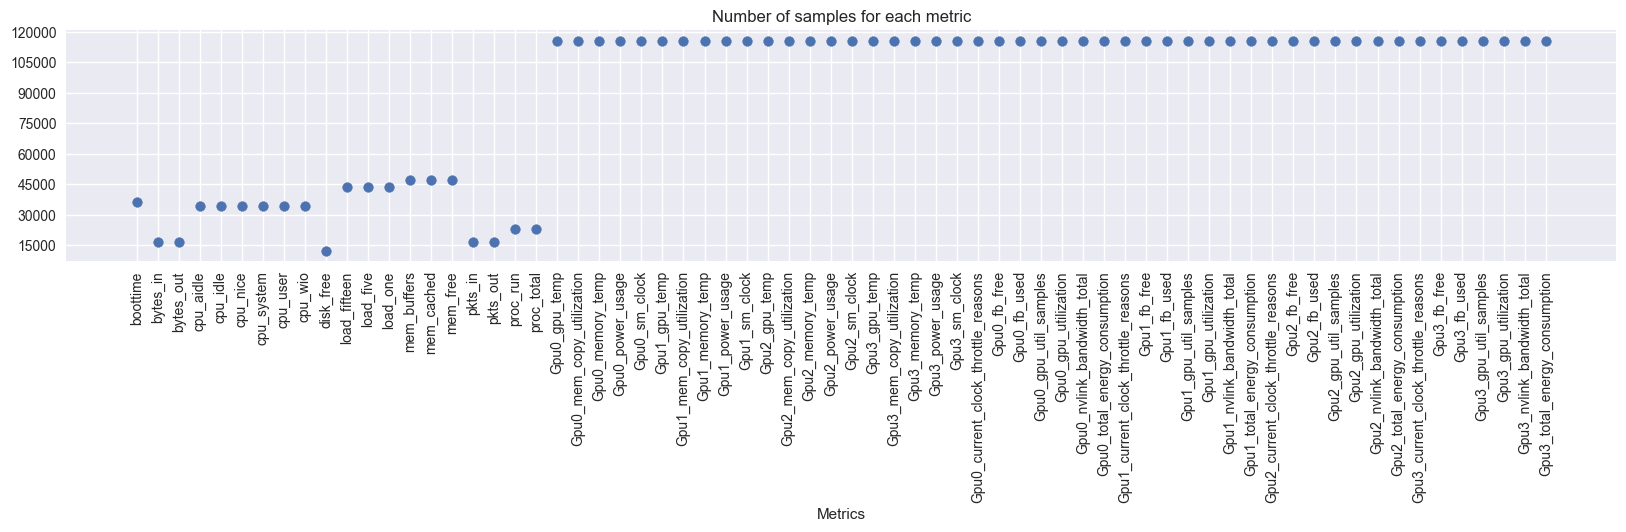

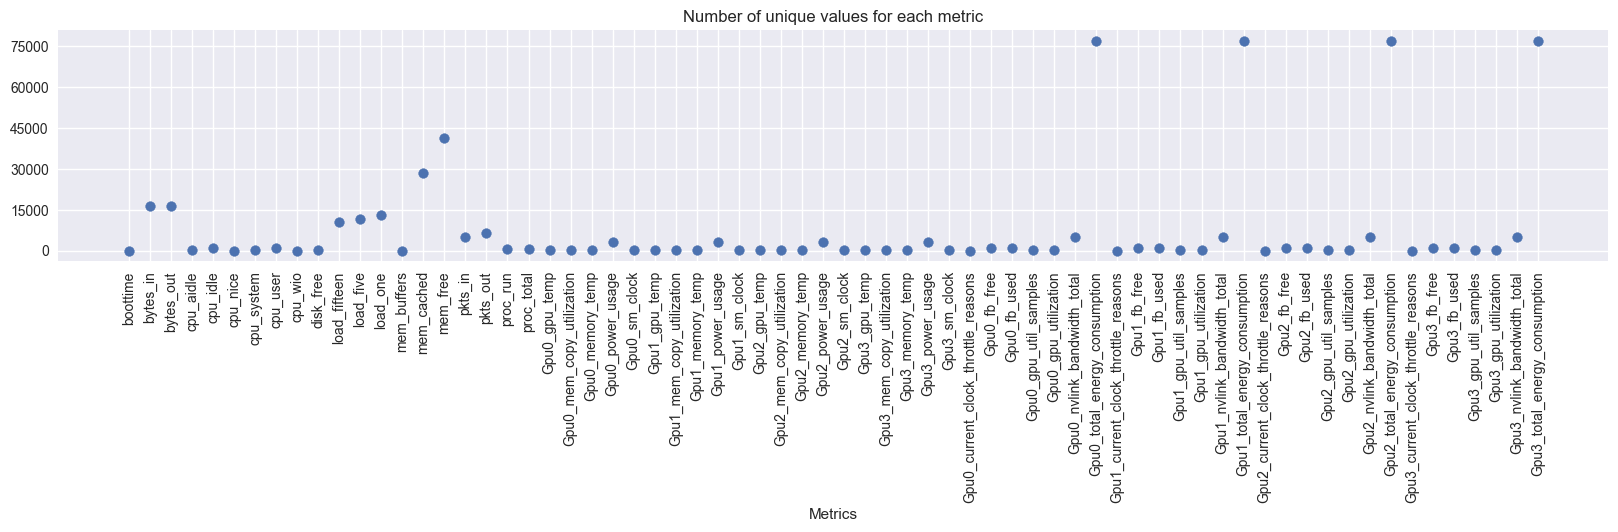

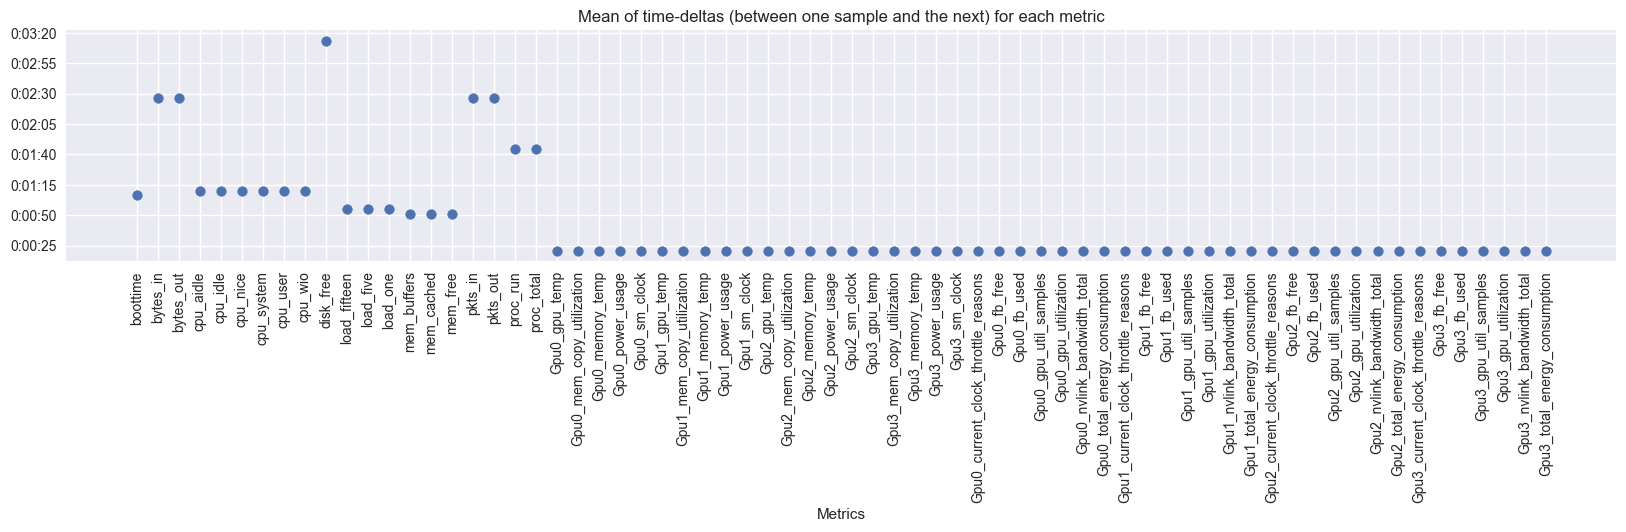

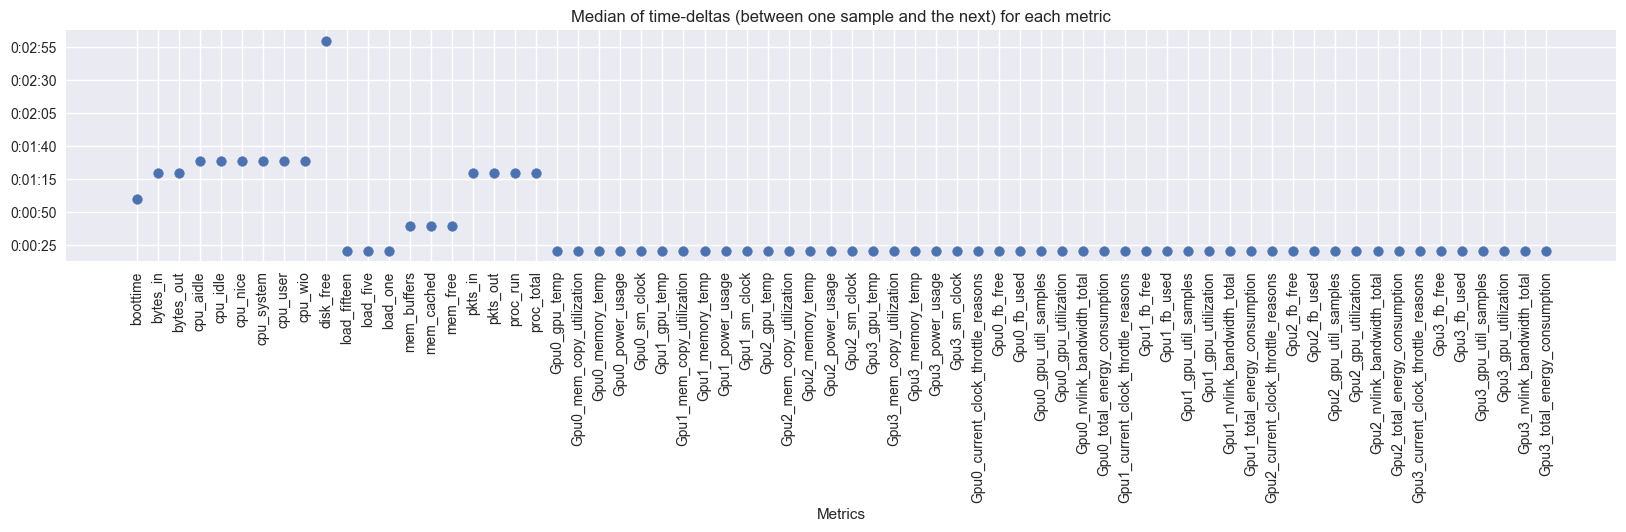

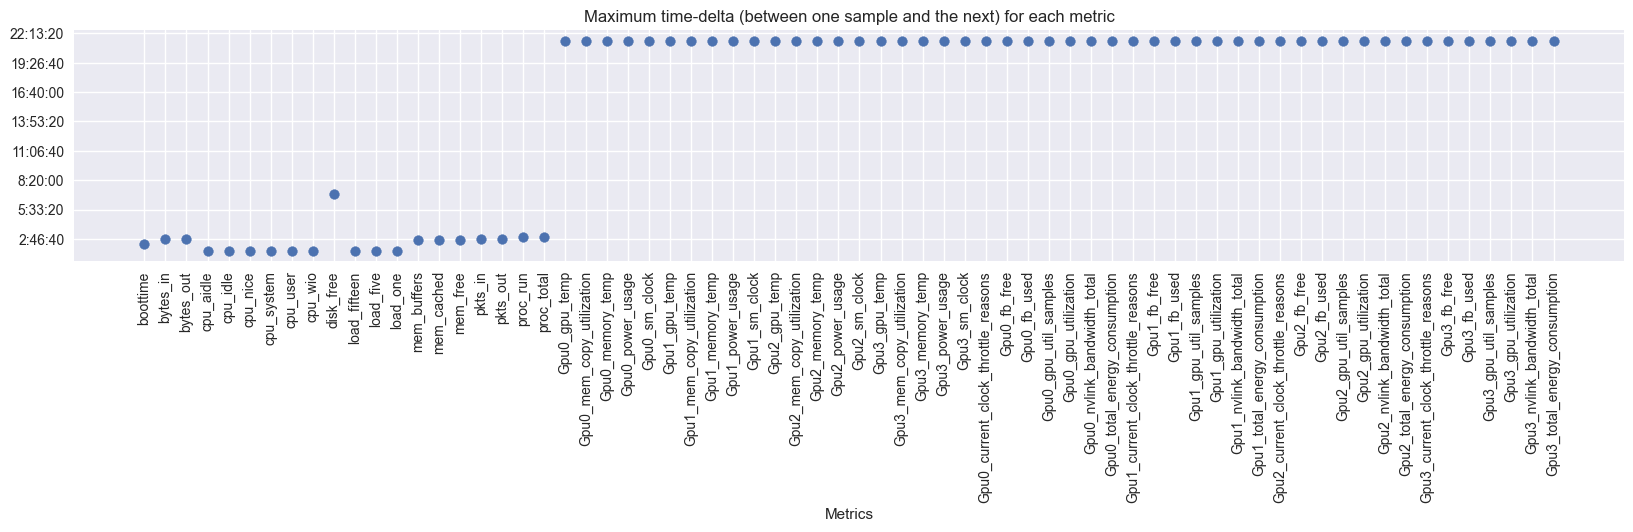

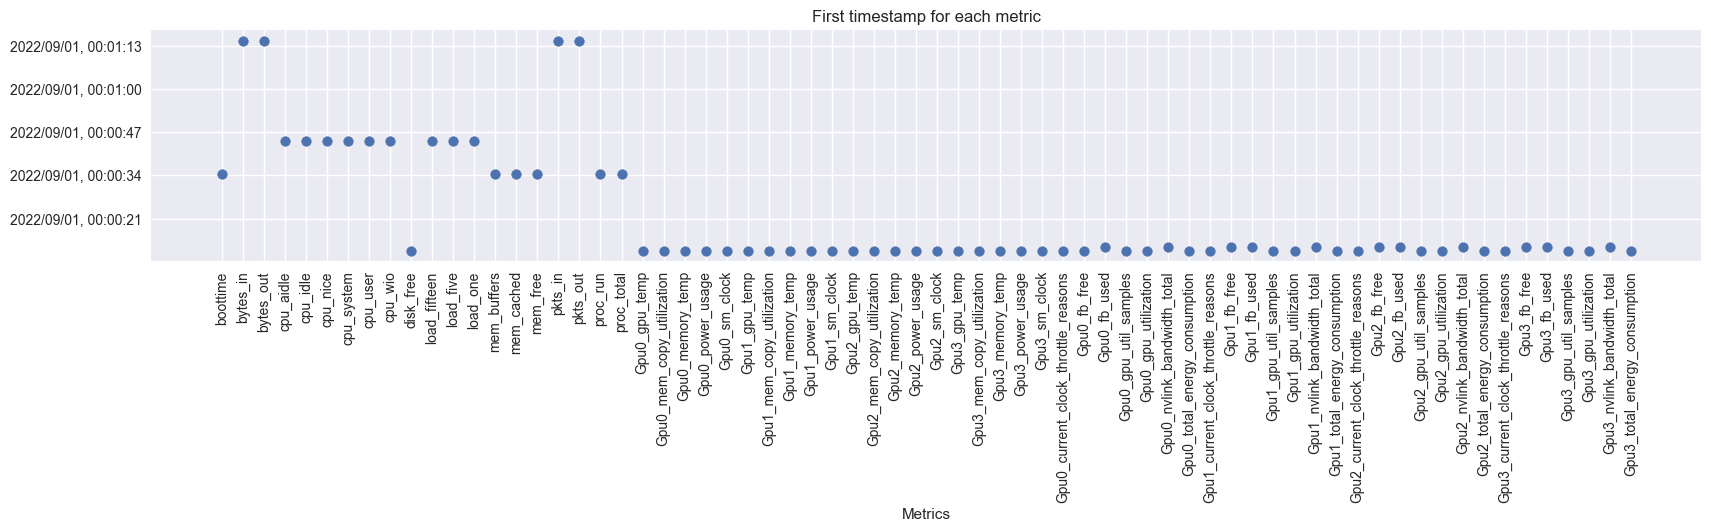

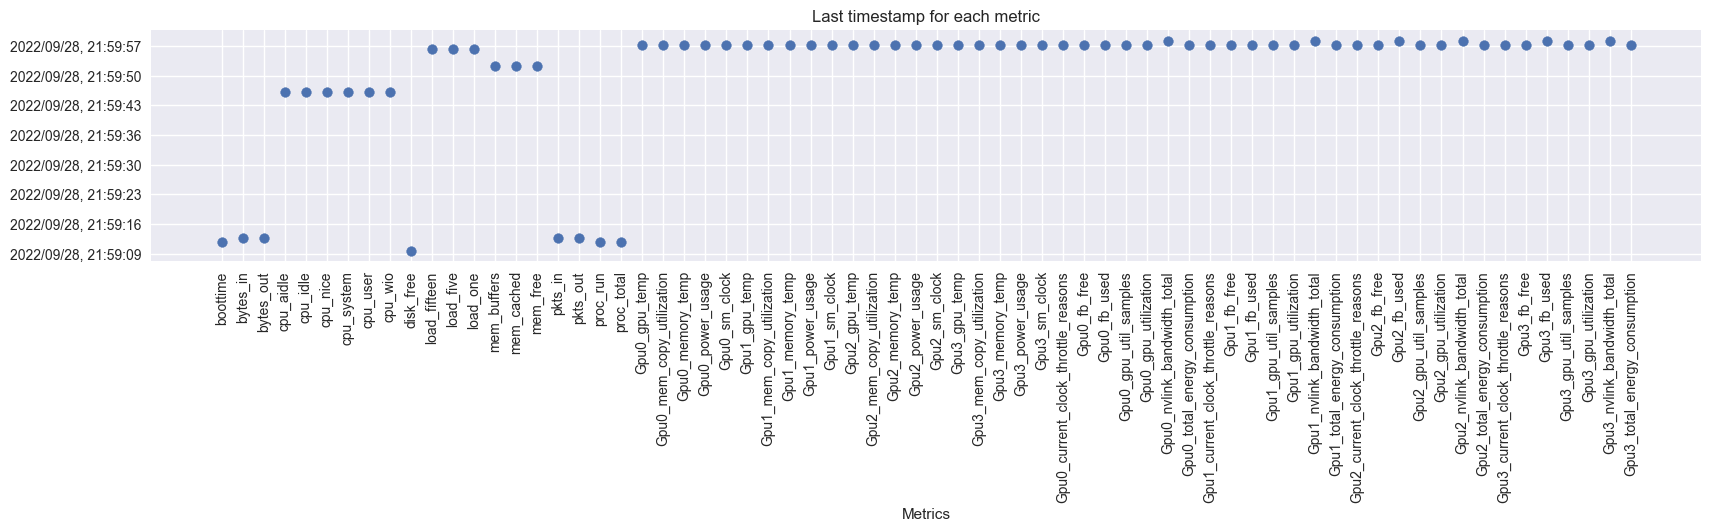

In [213]:
# Print statistics for each metric


def plot_samples_per_metric(df: pd.DataFrame):
    stats = {
        "Number of samples": [],
        "Number of unique values": [],
        "Mean of time-deltas (between one sample and the next)": [],
        "Median of time-deltas (between one sample and the next)": [],
        "Maximum time-delta (between one sample and the next)": [],
        "First timestamp": [],
        "Last timestamp": [],
    }

    for metric in metrics:
        # Build a new temporary df for each metric
        df_temp: pd.DataFrame = df.loc[df["metric"] == metric].reset_index()
        # New column of delta-times between each sample and the previous
        df_temp["timedelta"] = df_temp["timestamp"].diff()

        stats["Number of samples"].append(df_temp["timestamp"].shape[0])  # number of samples
        stats["Number of unique values"].append(len(df_temp["value"].unique()))  # number of unique values
        stats["Mean of time-deltas (between one sample and the next)"].append(
            timedelta(seconds=df_temp["timedelta"].dt.total_seconds().mean()).total_seconds()
        )  # mean of delta-times of all samples
        stats["Median of time-deltas (between one sample and the next)"].append(
            timedelta(seconds=df_temp["timedelta"].dt.total_seconds().median()).total_seconds()
        )  # median of delta-times of all samples
        stats["Maximum time-delta (between one sample and the next)"].append(
            timedelta(seconds=df_temp["timedelta"].dt.total_seconds().max()).total_seconds()
        )  # max of delta-time ever intercurred
        stats["First timestamp"].append(df_temp["timestamp"].min())  # first and last timestamp
        stats["Last timestamp"].append(df_temp["timestamp"].max())

    # Creazione dei grafici
    for stat_name, values in stats.items():
        _, ax = plt.subplots(figsize=(20, 3))
        # Create a custom formatter that converts seconds into strings of timedelta for timedelta values
        if "timestamp" in stat_name:
            ax.yaxis.set_major_formatter(mdates.DateFormatter("%Y/%m/%d, %H:%M:%S"))
        elif "time-delta" in stat_name:
            formatter = FuncFormatter(lambda x, pos: (str(timedelta(seconds=x))))
            ax.yaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_locator(MaxNLocator(nbins="auto", min_n_ticks=1))
        plt.scatter(metrics, values)
        plt.xlabel("Metrics")
        plt.tick_params(axis="x", labelrotation=90)
        plt.title(f"{stat_name} for each metric")
        plt.show()


plot_samples_per_metric(df_ganglia)

## Build the new dataframe

In [214]:
def rebuild_dataframe(df):
    df_rebuild = pd.DataFrame()
    for metric in metrics:
        # Build a new temporary df for each metric
        df_temp = df.loc[df["metric"] == metric][["timestamp", "value"]].rename(columns={"value": str(metric)})
        if df_rebuild.empty:
            df_rebuild = df_temp
        else:
            # Merge the temporary df to the main df
            df_rebuild = pd.merge(df_rebuild, df_temp, on=["timestamp"], how="outer")
    return df_rebuild.sort_values(by="timestamp").reset_index(drop=True)


df_ganglia_rebuild = rebuild_dataframe(df_ganglia)

### Aggregation of rows:

In [215]:
# Aggregation timestamps according to nagios time-delta (the sampling rate of nagios)
def aggregate_timestamps(df):
    # The operation of the aggregation is the mean
    return df.set_index("timestamp").resample(f"{NAGIOS_TIME_DELTA_MINS}min").mean()


df_ganglia_rebuild = aggregate_timestamps(df_ganglia_rebuild)

display(df_ganglia_rebuild.head(3))
df_ganglia_rebuild.info()

,boottime,bytes_in,bytes_out,cpu_aidle,cpu_idle,cpu_nice,cpu_system,cpu_user,cpu_wio,disk_free,...,Gpu2_gpu_utilization,Gpu2_nvlink_bandwidth_total,Gpu2_total_energy_consumption,Gpu3_current_clock_throttle_reasons,Gpu3_fb_free,Gpu3_fb_used,Gpu3_gpu_util_samples,Gpu3_gpu_utilization,Gpu3_nvlink_bandwidth_total,Gpu3_total_energy_consumption
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-09-01 00:00:00+00:00,1659944114.0,7457.306055,17513.688086,85.900002,94.055557,0.0,0.427778,5.522222,0.0,1135.232812,...,46.666667,29.511111,251791600025.600006,0.0,13724.044444,2435.955556,39.8,40.0,31.066667,232834022318.133331
2022-09-01 00:15:00+00:00,1659944114.0,12756.911377,19248.985107,85.900002,96.600001,0.0,0.294118,3.094118,0.0,1135.229199,...,33.333333,54.377778,251974633239.622223,0.133333,13002.777778,3157.066667,40.133333,37.577778,54.377778,233009251939.133331
2022-09-01 00:30:00+00:00,1659944114.0,6776.547363,16768.104492,85.900002,96.02414,0.0,0.113793,3.855172,0.0,1135.229004,...,2.222222,83.955556,252040921457.444458,0.0,10686.0,5474.0,1.422222,2.977778,83.955556,233076225605.311096


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2680 entries, 2022-09-01 00:00:00+00:00 to 2022-09-28 21:45:00+00:00
Freq: 15T
Data columns (total 68 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   boottime                             2587 non-null   object
 1   bytes_in                             2555 non-null   object
 2   bytes_out                            2555 non-null   object
 3   cpu_aidle                            2638 non-null   object
 4   cpu_idle                             2638 non-null   object
 5   cpu_nice                             2638 non-null   object
 6   cpu_system                           2638 non-null   object
 7   cpu_user                             2638 non-null   object
 8   cpu_wio                              2638 non-null   object
 9   disk_free                            2586 non-null   object
 10  load_fifteen                         2650 non-null

### Remove all empty rows:

In [216]:
df_ganglia_rebuild = df_ganglia_rebuild.dropna(how="all")

### Save rebuilt dataframe:

In [217]:
df_ganglia_rebuild.to_csv(dataset_path_rebuild + "/ganglia_rebuild_node" + NODE_SELECTED + ".csv", index=True)

In [218]:
# Clean up memory
%reset_selective -f ^df_
%reset_selective -f ^ax
%reset_selective -f ^non_numerical_features$

---
---
# IPMI Plugin

In [219]:
non_numerical_features = metrics_description(plugin="ipmi", verbose=False)
non_numerical_features

[]

### Get data:

In [220]:
df_ipmi: pd.DataFrame = (
    client.query_plugins(plugins="ipmi", node=NODE_SELECTED)
    .sort_values(by="timestamp", ascending=True)
    .reset_index(drop=True)
)

df_ipmi.info()
display(df_ipmi.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10536626 entries, 0 to 10536625
Data columns (total 6 columns):
 #   Column      Dtype              
---  ------      -----              
 0   year_month  category           
 1   timestamp   datetime64[ms, UTC]
 2   plugin      category           
 3   metric      category           
 4   value       Float64            
 5   node        category           
dtypes: Float64(1), category(4), datetime64[ms, UTC](1)
memory usage: 231.2 MB


,year_month,timestamp,plugin,metric,value,node
0,NaN,2022-09-01 00:00:00+00:00,ipmi_pub,p1_core10_temp,41.0,355
1,NaN,2022-09-01 00:00:00+00:00,ipmi_pub,p1_vdd_temp,33.0,355
2,NaN,2022-09-01 00:00:00+00:00,ipmi_pub,p1_power,26.0,355


### Cleaning rows and columns:

In [221]:
df_ipmi = df_ipmi[["timestamp", "value", "metric"]].reset_index(drop=True)

In [222]:
# Remove metrics that don't change in value
df_ipmi = remove_non_changing_metrics(df_ipmi)

In [223]:
# Verify if non-numerical metrics have distinct values
detect_distinct_non_numerical_values(df_ipmi)

In [224]:
# Present (remaining) metrics
metrics = df_ipmi["metric"].sort_values().unique()

### Display graphs:

In [225]:
if DISPLAY_GRAPHS:
    for metric in metrics:
        _, axes = plt.subplots(figsize=(16, 3))
        df_ipmi_plot = df_ipmi.loc[df_ipmi["metric"] == metric][["timestamp", "value"]]
        sns.scatterplot(df_ipmi_plot, x="timestamp", y="value", edgecolor="none", s=10, ax=axes)
        axes.set_title("{} - {} - (node {})".format("ipmi", metric, NODE_SELECTED))
        axes.set_xticks(all_days)
        axes.tick_params(axis="x", labelrotation=10)
        axes.xaxis.set_major_locator(MaxNLocator(nbins=15))
        axes.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        plt.tight_layout()
        plt.show()

## Verifications:

In [226]:
# Null rows
if df_ipmi.shape[0] - df_ipmi.dropna().shape[0] != 0:
    raise Exception("There are null rows in the ipmi dataframe")

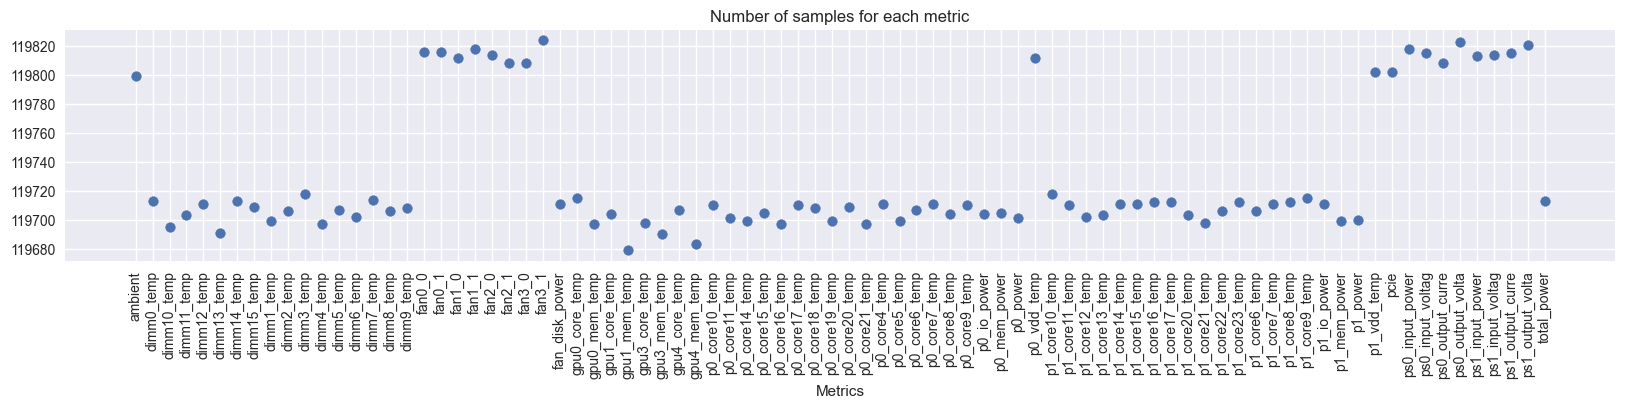

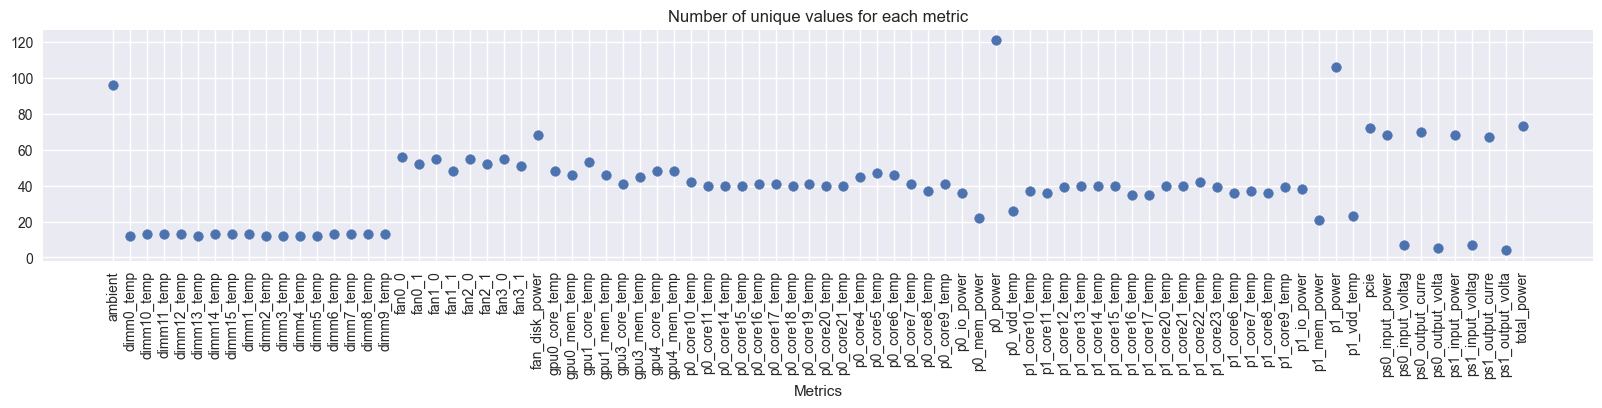

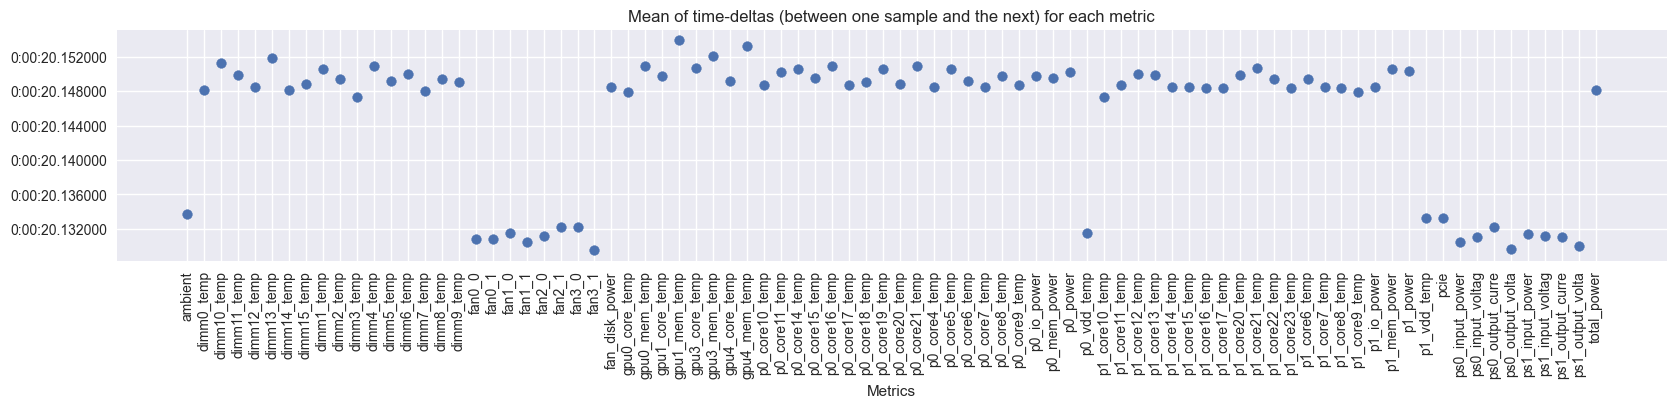

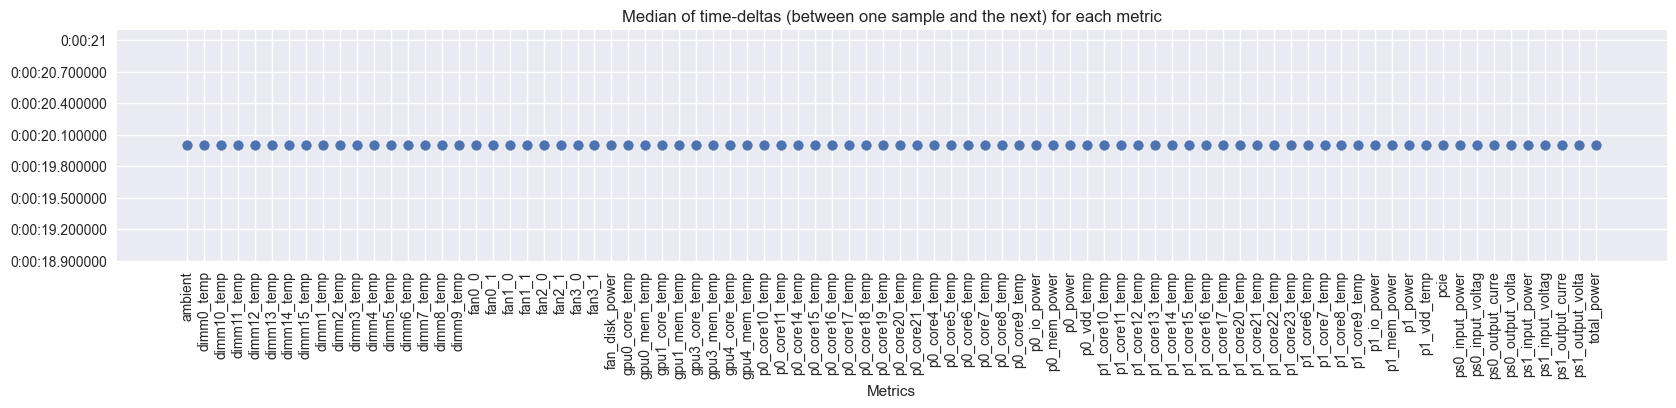

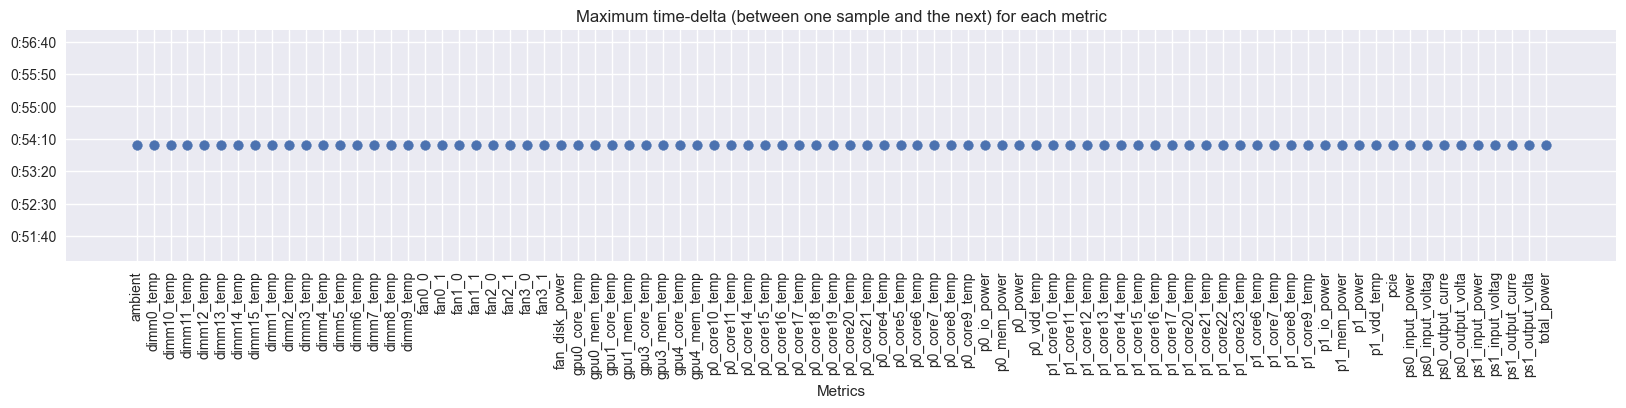

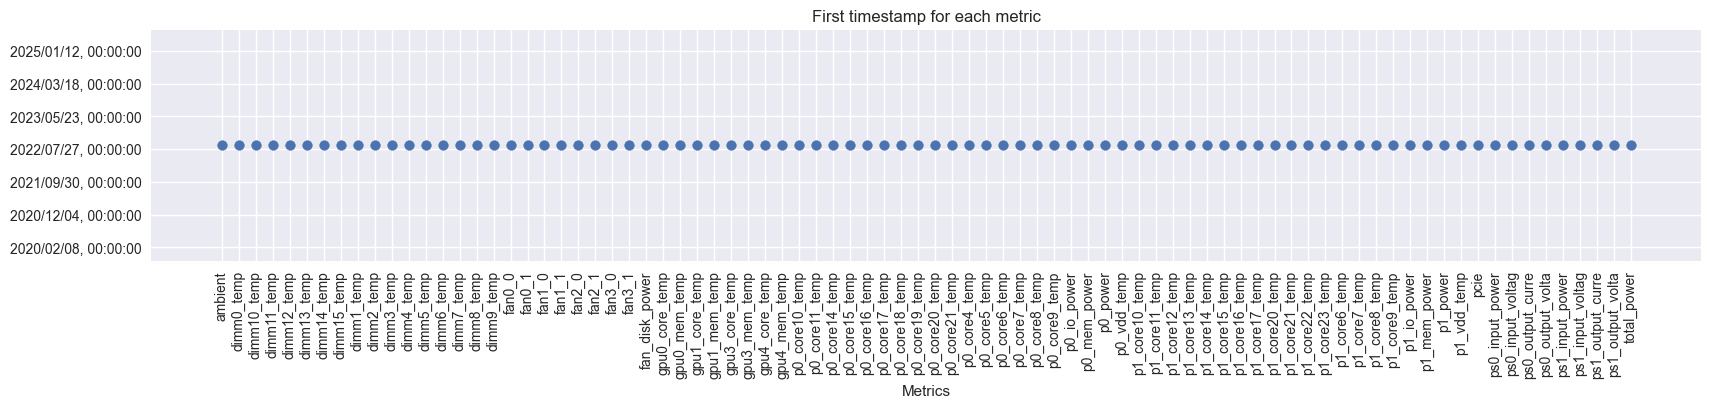

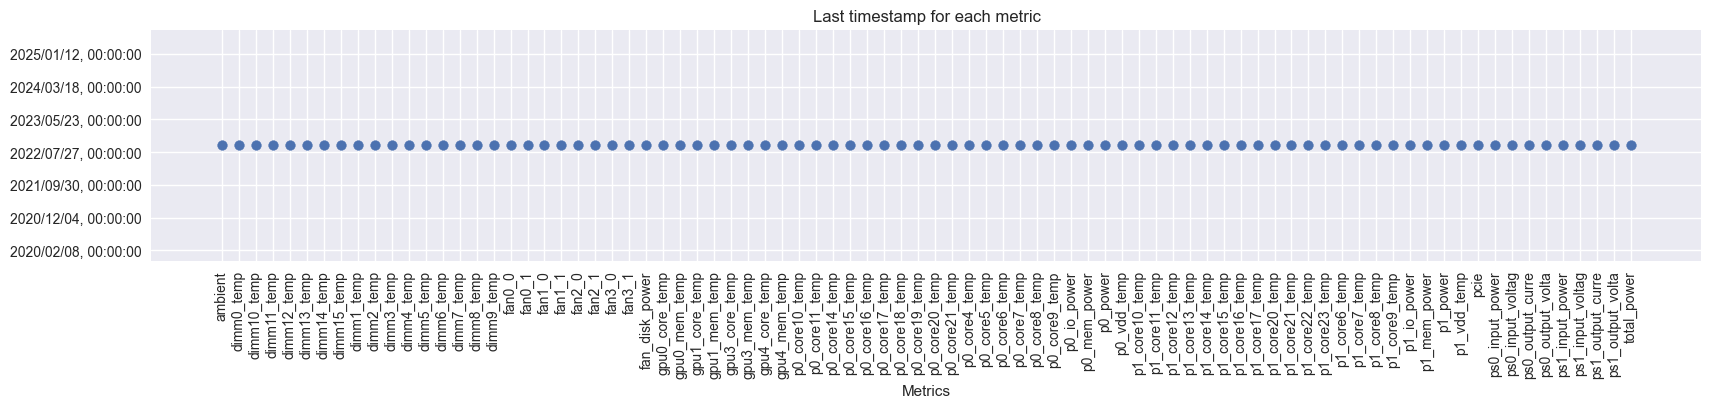

In [227]:
# Print statistics for each metric
plot_samples_per_metric(df_ipmi)

## Build the new dataframe

In [228]:
df_ipmi_rebuild = rebuild_dataframe(df_ipmi)

### Aggregation of rows:

In [229]:
# Aggregation timestamps according to nagios time-delta (the sampling rate of nagios)
df_ipmi_rebuild = aggregate_timestamps(df_ipmi_rebuild)

display(df_ipmi_rebuild.head(3))
df_ipmi_rebuild.info()

,ambient,dimm0_temp,dimm10_temp,dimm11_temp,dimm12_temp,dimm13_temp,dimm14_temp,dimm15_temp,dimm1_temp,dimm2_temp,...,pcie,ps0_input_power,ps0_input_voltag,ps0_output_curre,ps0_output_volta,ps1_input_power,ps1_input_voltag,ps1_output_curre,ps1_output_volta,total_power
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-09-01 00:00:00+00:00,25.355556,32.377778,32.155556,31.377778,32.377778,32.622222,31.511111,33.333333,33.222222,33.044444,...,42.413333,518.666667,228.0,37.311111,12.2,556.222222,228.0,39.688889,12.2,921.777778
2022-09-01 00:15:00+00:00,25.417778,32.266667,32.244444,31.377778,32.355556,32.644444,31.444444,33.333333,32.688889,32.555556,...,44.680001,460.444444,228.0,33.066667,12.224444,501.555556,228.0,35.755556,12.224444,815.555556
2022-09-01 00:30:00+00:00,25.182223,33.555556,32.955556,32.0,33.0,33.022222,32.022222,34.0,34.0,34.0,...,40.993332,314.222222,228.0,21.6,12.2,343.555556,228.0,23.533333,12.2,541.333333


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2680 entries, 2022-09-01 00:00:00+00:00 to 2022-09-28 21:45:00+00:00
Freq: 15T
Data columns (total 84 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ambient           2676 non-null   Float64
 1   dimm0_temp        2675 non-null   Float64
 2   dimm10_temp       2675 non-null   Float64
 3   dimm11_temp       2675 non-null   Float64
 4   dimm12_temp       2675 non-null   Float64
 5   dimm13_temp       2675 non-null   Float64
 6   dimm14_temp       2675 non-null   Float64
 7   dimm15_temp       2675 non-null   Float64
 8   dimm1_temp        2675 non-null   Float64
 9   dimm2_temp        2675 non-null   Float64
 10  dimm3_temp        2675 non-null   Float64
 11  dimm4_temp        2675 non-null   Float64
 12  dimm5_temp        2675 non-null   Float64
 13  dimm6_temp        2675 non-null   Float64
 14  dimm7_temp        2675 non-null   Float64
 15  dimm8_temp        2675 non-null

### Remove all empty rows:

In [230]:
df_ipmi_rebuild = df_ipmi_rebuild.dropna(how="all")

### Save rebuilt dataframe:

In [231]:
df_ipmi_rebuild.to_csv(dataset_path_rebuild + "/ipmi_rebuild_node" + NODE_SELECTED + ".csv", index=True)

In [232]:
# Clean up memory
%reset_selective -f ^df_
%reset_selective -f ^ax
%reset_selective -f ^metrics$

---
---
# Job table Plugin

In [233]:
# This plugin has only one metric called 'job_info_marconi100' with several features

In [234]:
non_numerical_features = metrics_description(plugin="job_table")

metric: 'job_info_marconi100'
	dtype: None
	tags: ['plugin', 'metric', 'year_month', 'accrue_time', 'alloc_node', 'alloc_sid', 'array_job_id', 'array_max_tasks', 'array_task_id', 'array_task_str', 'array_task_throttle', 'assoc_id', 'batch_flag', 'batch_host', 'billable_tres', 'bitflags', 'boards_per_node', 'contiguous', 'cores_per_socket', 'cpus_alloc_layout', 'cpus_allocated', 'cpus_per_task', 'cpus_per_tres', 'dependency', 'derived_ec', 'eligible_time', 'end_time', 'exc_nodes', 'exit_code', 'features', 'group_id', 'job_id', 'job_state', 'last_sched_eval', 'max_cpus', 'max_nodes', 'mem_per_cpu', 'mem_per_node', 'min_memory_cpu', 'min_memory_node', 'nice', 'nodes', 'ntasks_per_board', 'ntasks_per_core', 'ntasks_per_core_str', 'ntasks_per_node', 'ntasks_per_socket', 'ntasks_per_socket_str', 'num_cpus', 'num_nodes', 'num_tasks', 'partition', 'pn_min_cpus', 'pn_min_memory', 'pn_min_tmp_disk', 'power_flags', 'priority', 'profile', 'qos', 'reboot', 'req_nodes', 'req_switch', 'requeue', 'res

### Get data:

In [235]:
df_jobtable: pd.DataFrame = client.query_plugins(plugins="job_table")

### Cleaning rows and columns:

In [236]:
# Drop rows with NaN value in "nodes" feature
df_jobtable = df_jobtable.dropna(subset=["nodes"])

In [237]:
# Take only the rows of NODE_SELECTED
df_jobtable = df_jobtable.loc[
    list(
        map(
            lambda el: NODE_SELECTED in el,
            df_jobtable["nodes"]
            .str.replace("]", "")
            .str.replace("[", "")
            .str.replace(" ", "")
            .str.split(",")
            .to_list(),
        )
    )
]

In [238]:
# Sort by job "start_time"
df_jobtable = df_jobtable.sort_values("start_time").reset_index(drop=True)

# Drop empty features
df_jobtable = df_jobtable.dropna(axis=1)

df_jobtable.info()
display(df_jobtable.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   nice               183 non-null    Int32              
 1   job_state          183 non-null    category           
 2   array_job_id       183 non-null    UInt32             
 3   start_time         183 non-null    datetime64[ms, UTC]
 4   qos                183 non-null    category           
 5   plugin             183 non-null    category           
 6   user_id            183 non-null    UInt32             
 7   priority           183 non-null    UInt32             
 8   time_limit_str     183 non-null    string             
 9   metric             183 non-null    category           
 10  num_nodes          183 non-null    UInt16             
 11  contiguous         183 non-null    boolean            
 12  job_id             183 non-null    UInt32         

,nice,job_state,array_job_id,start_time,qos,plugin,user_id,priority,time_limit_str,metric,num_nodes,contiguous,job_id,num_cpus,group_id,cpus_alloc_layout,partition,submit_time,nodes,end_time
0,0,COMPLETED,2770082,2022-08-31 23:23:24+00:00,4,job_table,195,190080,1:30:00,job_info_marconi100,64,False,2770082,8192,25200,"{766: [], 795: [], 585: [], 648: [], 20: [], 6...",1,2022-08-31 08:12:53+00:00,"[79, 107, 141, 189, 239, 268, 287, 318, 355, 7...",2022-09-01 00:21:35+00:00
1,0,COMPLETED,2992472,2022-09-01 00:23:21+00:00,4,job_table,195,190205,1:30:00,job_info_marconi100,64,False,2992472,8192,25200,"{766: [], 585: [], 648: [], 20: [], 691: [], 8...",1,2022-08-31 08:12:53+00:00,"[79, 107, 141, 189, 239, 268, 287, 318, 355, 7...",2022-09-01 01:21:22+00:00
2,0,COMPLETED,3042891,2022-09-01 01:23:21+00:00,4,job_table,195,190315,1:30:00,job_info_marconi100,64,False,3042891,8192,25200,"{766: [], 806: [], 585: [], 648: [], 20: [], 6...",1,2022-08-31 08:12:53+00:00,"[79, 107, 141, 189, 239, 268, 287, 318, 355, 7...",2022-09-01 02:21:49+00:00


In [239]:
# Job states
job_states = df_jobtable["job_state"].unique()

### Display graphs:

In [240]:
# Display, for each job, execution start and end time points, connected with a line

if DISPLAY_GRAPHS:

    # Plot all states
    _, axes = plt.subplots(figsize=(16, 3))
    df_jobtable_plot = df_jobtable

    for index, row in df_jobtable_plot.iterrows():
        color = "b" if row["job_state"] == "COMPLETED" else "red"
        axes.plot([row["start_time"], row["end_time"]], [index, index], color=color, linewidth=3)

    axes.set_title("{}\n (node {})".format("Moments when the node is executing (all job_states)", NODE_SELECTED))
    axes.set_xticks(all_days)
    axes.tick_params(axis="x", labelrotation=10)
    axes.xaxis.set_major_locator(MaxNLocator(nbins=20))
    axes.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    axes.set_ylabel("job index on df")
    plt.tight_layout()
    plt.show()

    # Plot single job_state
    for descr in job_states:
        _, axes = plt.subplots(figsize=(16, 3))
        df_jobtable_plot = df_jobtable.loc[df_jobtable["job_state"] == descr]

        axes.scatter(df_jobtable_plot["start_time"], df_jobtable_plot.index, label="start")
        axes.scatter(df_jobtable_plot["end_time"], df_jobtable_plot.index, label="end")

        for index, row in df_jobtable_plot.iterrows():
            axes.plot([row["start_time"], row["end_time"]], [index, index], color="b", linewidth=2)

        axes.legend()
        axes.set_title("job_state: {}\n (node {})".format(descr, NODE_SELECTED))
        axes.set_xticks(all_days)
        axes.tick_params(axis="x", labelrotation=10)
        axes.xaxis.set_major_locator(MaxNLocator(nbins=20))
        axes.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        axes.set_ylabel("job index on df")
        plt.tight_layout()
        plt.show()

## Verifications:

In [241]:
# Null rows
if df_jobtable.shape[0] - df_jobtable.dropna().shape[0] != 0:
    raise Exception("There are null rows in the ipmi dataframe")

## Build the new dataframe
- It's composed by:
    - "timestamp": a series of timestamps, equally spaced by NAGIOS_TIME_DELTA_MINS, from the start to the end of nagios timestamp range
    - "state": the state of the job executing in that moment. At the end this feature is given to a OneHotEncoder
- If any job is not executing at a given timestamp, the state is set to "IDLE"
- If more than one job is executing at the same timestamp, the state of the *longer* job is taken

### Problem:
A new observation would never possess the job state at any time instant, because the state of a job is known at the end of the job itself. The only information that can be always obtained is if the node is running any job or not: that is the "IDLE" column. Therefore, that's the only column taken.

For completeness, the code of extracting all the states is kept

In [242]:
df_jobtable_rebuild = pd.DataFrame()

df_jobtable_rebuild["timestamp"] = [first_nagios_timestamp, last_nagios_timestamp]
# Little hack to create the timeseries:
df_jobtable_rebuild = aggregate_timestamps(df_jobtable_rebuild).reset_index("timestamp")

# Create the new column "state" set to None
df_jobtable_rebuild["state"] = None

# The dataset NEEDS to be sorted by "start_time":
df_jobtable = df_jobtable.sort_values("start_time").reset_index(drop=True)[["job_state", "start_time", "end_time"]]
index = 0

# For each timestamp
for i_ts, ts in df_jobtable_rebuild.iterrows():

    job_duration_previous = None  # in case there are parallel jobs

    # For each job (progressively excluded the jobs before the timestamp)
    for i_job, job in df_jobtable.iloc[index:].iterrows():
        # if the timestamp is before the job, pass to the next timestamp
        if ts.timestamp < job.start_time:
            break

        # if the timestamp is within the job execution
        if job.start_time <= ts.timestamp and ts.timestamp <= job.end_time:
            job_duration = job.end_time - job.start_time
            # if it's the firt job executing in this timestamp:
            if job_duration_previous == None:
                df_jobtable_rebuild.at[i_ts, "state"] = job.job_state
                job_duration_previous = job_duration
            else:  # otherwise if there is already another job running, and if that job has longer duration:
                if job_duration_previous < job_duration:
                    df_jobtable_rebuild.at[i_ts, "state"] = job.job_state
                    job_duration_previous = job_duration

        else:  # the timestamp is after the job, so all the subsequent timestamp are after it, therefore it's removed from the list
            index += 1

# Fill the idle timestamps
df_jobtable_rebuild = df_jobtable_rebuild.fillna("IDLE")

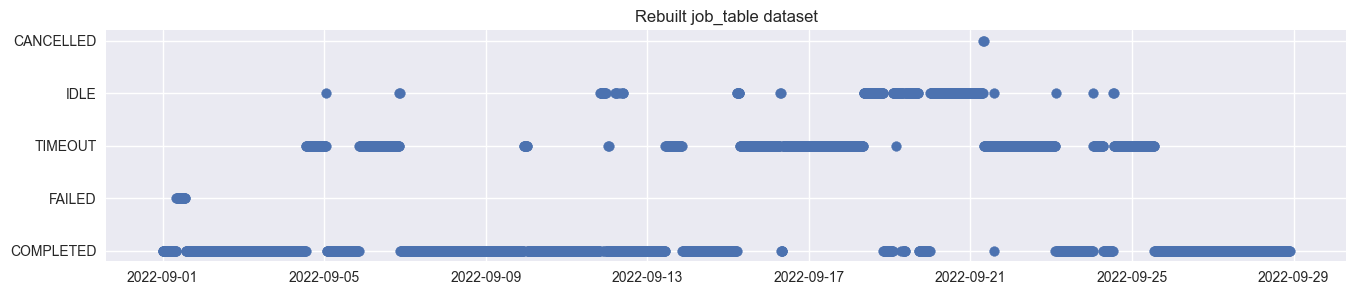

In [243]:
_, axes = plt.subplots(figsize=(16, 3))
axes.scatter(df_jobtable_rebuild.timestamp, df_jobtable_rebuild.fillna("None").state)
plt.title("Rebuilt job_table dataset")
plt.show()

In [244]:
# One Hot Encoding of the "state"
df_jobtable_rebuild = pd.get_dummies(df_jobtable_rebuild.set_index("timestamp"), dtype=int)
df_jobtable_rebuild.head(3)

,state_CANCELLED,state_COMPLETED,state_FAILED,state_IDLE,state_TIMEOUT
timestamp,,,,,
2022-09-01 00:00:00+00:00,0,1,0,0,0
2022-09-01 00:15:00+00:00,0,1,0,0,0
2022-09-01 00:30:00+00:00,0,1,0,0,0


In [245]:
# Keeping only the "state_IDLE" feature
df_jobtable_rebuild = df_jobtable_rebuild.loc[:, "state_IDLE"]

### Save rebuilt dataframe:

In [246]:
df_jobtable_rebuild.to_csv(dataset_path_rebuild + "/jobtable_rebuild_node" + NODE_SELECTED + ".csv", index=True)

In [247]:
# Clean up memory
%reset_selective -f ^df_jobtable
%reset_selective -f ^job_states$
%reset_selective -f ^ax

---
---
# Logics Plugin

In [248]:
non_numerical_features = metrics_description(plugin="logics", verbose=False)
non_numerical_features

['Prototype', 'address', 'Gateway']

### Get data:

In [249]:
df_logics = client.query_plugins(plugins="logics")

df_logics.info()
display(df_logics.head(3))

c:\Users\evang.HOMEEVANGELISTI\git\HPC-Anomaly-Detection\query_tool\query_tool.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, table.to_pandas(**to_pandas_kwargs)], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38835580 entries, 0 to 38835579
Data columns (total 7 columns):
 #   Column      Dtype              
---  ------      -----              
 0   year_month  category           
 1   timestamp   datetime64[ms, UTC]
 2   plugin      category           
 3   device      object             
 4   metric      category           
 5   value       Float64            
 6   panel       object             
dtypes: Float64(1), category(3), datetime64[ms, UTC](1), object(2)
memory usage: 1.3+ GB


,year_month,timestamp,plugin,device,metric,value,panel
0,NaN,2022-09-04 12:25:50+00:00,logics_pub,qe-20a-n,Bad_values,1.0,marconi-a3
1,NaN,2022-09-04 12:26:50+00:00,logics_pub,qe-20a-n,Bad_values,0.0,marconi-a3
2,NaN,2022-09-04 12:33:53+00:00,logics_pub,qe-20a-n,Bad_values,1.0,marconi-a3


### _Problem_
the position of the node w.r.t. the panel code is not available

In [250]:
# Clean up memory
%reset_selective -f ^df_
%reset_selective -f ^ax

---
---
# Schneider Plugin

In [251]:
non_numerical_features = metrics_description(plugin="schneider", verbose=False)
non_numerical_features

[]

### Get data:

In [252]:
df_schneider = client.query_plugins(plugins="schneider")

df_schneider.info()
display(df_schneider.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33554432 entries, 0 to 33554431
Data columns (total 6 columns):
 #   Column      Dtype              
---  ------      -----              
 0   year_month  category           
 1   timestamp   datetime64[ms, UTC]
 2   plugin      category           
 3   metric      category           
 4   value       Int32              
 5   panel       category           
dtypes: Int32(1), category(4), datetime64[ms, UTC](1)
memory usage: 576.0 MB


,year_month,timestamp,plugin,metric,value,panel
0,NaN,2022-09-23 22:00:00+00:00,schneider_pub,Alm_TY141,0,Q101
1,NaN,2022-09-23 23:00:00+00:00,schneider_pub,Alm_TY141,0,Q101
2,NaN,2022-09-02 22:00:00+00:00,schneider_pub,Alm_TY141,0,Q101


### _Problem_
the position of the node w.r.t. the panel code is not available

In [253]:
# Clean up memory
%reset_selective -f ^df_
%reset_selective -f ^ax

---
---
# Slurm Plugin 

In [254]:
non_numerical_features = metrics_description(plugin="slurm", verbose=False)
non_numerical_features

[]

### Get data:

In [255]:
df_slurm = client.query_plugins(plugins="slurm")

df_slurm.info()
display(df_slurm.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59574539 entries, 0 to 59574538
Data columns (total 9 columns):
 #   Column      Dtype              
---  ------      -----              
 0   timestamp   datetime64[ms, UTC]
 1   plugin      category           
 2   metric      category           
 3   value       Float64            
 4   user_id     UInt32             
 5   year_month  category           
 6   partition   category           
 7   job_state   category           
 8   qos         category           
dtypes: Float64(1), UInt32(1), category(6), datetime64[ms, UTC](1)
memory usage: 1.6 GB


,timestamp,plugin,metric,value,user_id,year_month,partition,job_state,qos
0,2022-09-14 22:00:00+00:00,slurm_pub,job_id,1348166.0,393,NaN,1,FAILED,NaN
1,2022-09-07 22:00:00+00:00,slurm_pub,job_id,1653075.0,366,NaN,1,COMPLETED,NaN
2,2022-09-13 23:00:00+00:00,slurm_pub,job_id,1147583.0,478,NaN,1,COMPLETED,NaN


### _Problem_
the position of the node w.r.t. the partition code is not available

In [256]:
# Clean up memory
%reset_selective -f ^df_
%reset_selective -f ^ax
%reset_selective -f ^non_numerical_features